# SQL Analysis on Ford Go Bike

In [4]:
import pandas as pd
%matplotlib inline

## Overview

In this assignment, we are employing Ford GoBike's trip data which are publicly available in order to answer two questions:
1. What are the 5 most popular trips that you would call "commuter trips"?
2. What are your recommendations for offers? 

Ford GoBike is a bike share program located in the Bay Area. 

## What are the 5 most popular trips that you would call "commuter trips"?

I will define "commuter trips" with the following assumptions:  
* It has to occur within the same day.
* It has to occur in a weekday.
* A one-way commute is 19 minutes or less. 
  * Based on the US Census Bureau's data <sup>1</sup>, the median commute time for those who bike to work one-way is approximately 19 minutes. 
* It has a different start and end station.
* Because Ford GoBike is located in the Bay Area and the Bay Area has flexible work schedules <sup>2</sup>, there is no set time when people come in or leave work. For this reason, I will not limit the time range to the common morning (7-9 AM) and evening (4-6 PM) commute time. 

According to our definition of "commuter trips," the 5 most popular commuter trips are: 

### Via Query

In [6]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  start_station_name, \
  end_station_name, \
  COUNT(*) AS count \
FROM \
  `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE \
  DATE(start_date) = DATE(end_date) \
  AND EXTRACT(DAYOFWEEK FROM start_date AT TIME ZONE "America/Los_Angeles") NOT IN (7, 1) \
  AND EXTRACT(DAYOFWEEK FROM end_date AT TIME ZONE "America/Los_Angeles") NOT IN (7, 1) \
  AND duration_sec/60 <= 19 \
  AND start_station_id <> end_station_id \
GROUP BY \
  start_station_name, \
  end_station_name \
ORDER BY \
  count DESC \
LIMIT \
  5; \
'

Waiting on bqjob_rd3d5784e1397dd3_00000161b99875f5_1 ... (0s) Current status: DONE   
+-----------------------------------------+------------------------------------------+-------+
|           start_station_name            |             end_station_name             | count |
+-----------------------------------------+------------------------------------------+-------+
| San Francisco Caltrain 2 (330 Townsend) | Townsend at 7th                          |  7965 |
| 2nd at Townsend                         | Harry Bridges Plaza (Ferry Building)     |  6878 |
| Townsend at 7th                         | San Francisco Caltrain 2 (330 Townsend)  |  6361 |
| Embarcadero at Sansome                  | Steuart at Market                        |  6318 |
| Embarcadero at Folsom                   | San Francisco Caltrain (Townsend at 4th) |  6084 |
+-----------------------------------------+------------------------------------------+-------+


### Via CSV

In [7]:
! bq query --use_legacy_sql=FALSE --format=csv '\
SELECT \
  start_station_name, \
  end_station_name, \
  COUNT(*) AS count \
FROM \
  `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE \
  DATE(start_date) = DATE(end_date) \
  AND EXTRACT(DAYOFWEEK FROM start_date AT TIME ZONE "America/Los_Angeles") NOT IN (7, 1) \
  AND EXTRACT(DAYOFWEEK FROM end_date AT TIME ZONE "America/Los_Angeles") NOT IN (7, 1) \
  AND duration_sec/60 <= 19 \
  AND start_station_id <> end_station_id \
GROUP BY \
  start_station_name, \
  end_station_name \
ORDER BY \
  count DESC \
LIMIT \
  5; \
' > top_5_commuter_trips.csv

Waiting on bqjob_r29d40ad332c03ea8_00000161b999d35a_1 ... (0s) Current status: DONE   

In [8]:
top_5_commuter_trips = pd.read_csv('top_5_commuter_trips.csv')
top_5_commuter_trips

,start_station_name,end_station_name,count
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,7965
1,2nd at Townsend,Harry Bridges Plaza (Ferry Building),6878
2,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),6361
3,Embarcadero at Sansome,Steuart at Market,6318
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),6084


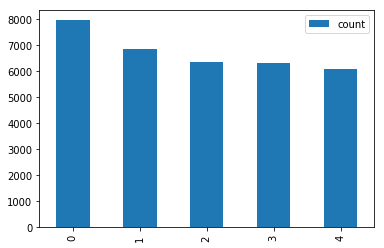

In [17]:
top_5_commuter_trips.plot(kind='bar')

### If Bay Area did not offer flexible work schedules

If Bay Area did not offer flexible work schedules and people commute in the morning around 7-9 AM and in the evening around 4-6 PM, the 5 most popular commuter trips are:

In [1]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  start_station_name, \
  end_station_name, \
  COUNT(*) AS count \
FROM \
  `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE \
  DATE(start_date) = DATE(end_date) \
  AND EXTRACT(DAYOFWEEK FROM start_date AT TIME ZONE "America/Los_Angeles") NOT IN (7, 1) \
  AND EXTRACT(DAYOFWEEK FROM end_date AT TIME ZONE "America/Los_Angeles") NOT IN (7, 1) \
  AND duration_sec/60 <= 19 \
  AND start_station_id <> end_station_id \
  AND ( \
    (\
      EXTRACT(HOUR FROM start_date AT TIME ZONE "America/Los_Angeles") >= 7 \
      AND EXTRACT(HOUR FROM end_date AT TIME ZONE "America/Los_Angeles") <= 9 \
    )\
    OR \
    (\
      EXTRACT(HOUR FROM start_date AT TIME ZONE "America/Los_Angeles") >= 16 \
      AND EXTRACT(HOUR FROM end_date AT TIME ZONE "America/Los_Angeles") <= 18 \
    )\
  )\
GROUP BY \
  start_station_name, \
  end_station_name \
ORDER BY \
  count DESC \
LIMIT \
  5; \
'

Waiting on bqjob_r72f5a5292321a9d9_00000161bb7cec9f_1 ... (3s) Current status: DONE   
+-----------------------------------------------+------------------------------------------+-------+
|              start_station_name               |             end_station_name             | count |
+-----------------------------------------------+------------------------------------------+-------+
| 2nd at Townsend                               | Harry Bridges Plaza (Ferry Building)     |  2843 |
| Embarcadero at Folsom                         | San Francisco Caltrain (Townsend at 4th) |  2561 |
| Temporary Transbay Terminal (Howard at Beale) | San Francisco Caltrain (Townsend at 4th) |  2278 |
| Steuart at Market                             | San Francisco Caltrain (Townsend at 4th) |  2010 |
| Embarcadero at Sansome                        | Steuart at Market                        |  2003 |
+-----------------------------------------------+------------------------------------------+-------+


The number of trips drops considerably. Also, the top 5 commuter trips under this assumption are mostly different than the ones listed above. 

## Closing Thoughts

What is interesting to note is that I would have expected the start and end station pair to have its respective vice-versa pair with the same number of counts, thereby placing the vice-versa pair also in the top 5. For example, I expected that (2nd at Townsend, Harry Bridges Plaza) and (Harry Bridges Plaza, 2nd at Townsend) have the same number of counts and therefore are in the top 5, but that is not the case. Further research is necessary to determine if people commuted differently in the morning than in the evening.

## What are your recommendations for offers?

Ford GoBike currently offers the following plan:  
* a flat price of \$3 for a single 30-minute one-way trip (extra \$3 per additional 15 minutes)
* a day pass of \$9.95 that allows unlimited 30-minute rides for 24 hours (extra \$3 per additional 15 minutes)
* an annual membership of \$149 per year

Without an ID, we do not know which subscriber/customer rides which trip. Also, we cannot differentiate between the specific subscriber type. We do not know if a subscriber is an annual or a 30-day member or if a customer is a 24-hour or a 3-day member.  

My recommendations for offers are provided in the "Conclusion."

## Fact \#1
With that said, we know that subscribers constitute 86% of all trips.

In [10]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  COUNT(DISTINCT trip_id) AS total_num_trips, \
  SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 end) AS num_subscriber_trips, \
  SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS num_customer_trips \
FROM \
 `bigquery-public-data.san_francisco.bikeshare_trips`; \
'

Waiting on bqjob_r3f79e6418e4d3fdc_00000161bc17656b_1 ... (3s) Current status: DONE   
+-----------------+----------------------+--------------------+
| total_num_trips | num_subscriber_trips | num_customer_trips |
+-----------------+----------------------+--------------------+
|          983648 |               846839 |             136809 |
+-----------------+----------------------+--------------------+


In [22]:
total_num_trips = 983648
num_subscriber_trips = 846839
num_customer_trips = 136809
def percentage(part, whole):
    return float(part)/float(whole) * 100

In [23]:
# percentage of trips taken by subscribers
percentage(num_subscriber_trips, total_num_trips)

86.09167100426168

In [24]:
# percentage of trips taken by customers
percentage(num_customer_trips, total_num_trips)

13.908328995738312

## Fact \# 2
We also know that one-way trips constitutes 96% of all trips, and subscribers in general tend to take one-way trips more often than customers.

In [15]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  COUNT(*) AS total_num_one_way_trips, \
  SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 end) AS num_subscriber_one_way_trips, \
  SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS num_customer_one_way_trips \
FROM \
 `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE \
  start_station_id <> end_station_id; \
'

Waiting on bqjob_r5fe08cbf7527e239_00000161bc1d6405_1 ... (1s) Current status: DONE   
+-------------------------+------------------------------+----------------------------+
| total_num_one_way_trips | num_subscriber_one_way_trips | num_customer_one_way_trips |
+-------------------------+------------------------------+----------------------------+
|                  951601 |                       836945 |                     114656 |
+-------------------------+------------------------------+----------------------------+


In [25]:
total_num_one_way_trips = 951601
num_subscriber_one_way_trips = 836945
num_customer_one_way_trips = 114656

In [26]:
# percentage of trips that are one-way trips
percentage(total_num_one_way_trips, total_num_trips)

96.7420256026546

In [31]:
# percentage of trips taken by subscribers that are one-way
percentage(num_subscriber_one_way_trips, total_num_trips)

85.08582338397476

In [32]:
# percentage of trips taken by customers that are one-way
percentage(num_customer_one_way_trips, total_num_trips)

11.656202218679853

In [27]:
# percentage of one-way trips taken by subscribers
percentage(num_subscriber_one_way_trips, total_num_one_way_trips)

87.95125267838097

In [28]:
# percentage of one-way trips taken by customers
percentage(num_customer_one_way_trips, total_num_one_way_trips)

12.04874732161904

In [29]:
# percentage of all subscriber trips that are one-way 
percentage(num_subscriber_one_way_trips, num_subscriber_trips)

98.83165513161298

In [30]:
# percentage of all customer trips that are one-way
percentage(num_customer_one_way_trips, num_customer_trips)

83.80735185550658

## Fact \# 3

On average, customers (62 minutes) tend to bike longer than subscribers (10 minutes). Interesting to note is that the length of time customers rent the bikes vary widely when you compare it to the length of time subscribers rent the bikes. It might be partially due to the outliers in the data. For example, the longest time a customer ever rent a bike is 200 days compared to that of a subscriber at 21 days. 

Since I was not able to download all of the data into a CSV because of the sheer volume, I was not able to confirmed whether or not the data have a skewed distribution.

In [117]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  subscriber_type, \
  AVG(duration_sec/60) AS average_trip_duration_min, \
  STDDEV(duration_sec/60) AS sd_trip_duration_min, \
  MIN(duration_sec/60) AS min_trip_duration_min, \
  MAX(duration_sec/60) AS max_trip_duration_min \
FROM \
 `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY \
  subscriber_type; \
'

Waiting on bqjob_r347254b14ff4acb5_00000161bc8d0408_1 ... (23s) Current status: DONE   
+-----------------+---------------------------+----------------------+-----------------------+-----------------------+
| subscriber_type | average_trip_duration_min | sd_trip_duration_min | min_trip_duration_min | max_trip_duration_min |
+-----------------+---------------------------+----------------------+-----------------------+-----------------------+
| Customer        |         61.97975267221685 |    812.8085318495606 |                   1.0 |              287840.0 |
| Subscriber      |         9.712737328662122 |    48.24265348752558 |                   1.0 |               30876.5 |
+-----------------+---------------------------+----------------------+-----------------------+-----------------------+


In [128]:
# 95% confidence interval for the subscriber's trip duration
subscriber_mean = 9.712737328662122
subscriber_sd = 48.24265348752558
"Subscriber's 95% CI: ({}, {})".format(subscriber_mean - 1.96 * subscriber_sd, subscriber_mean + 1.96 * subscriber_sd)

"Subscriber's 95% CI: (-84.84286350688802, 104.26833816421225)"

In [129]:
# 95% confidence interval for the customer's trip duration
customer_mean = 61.97975267221685
customer_sd = 812.8085318495606
"Customer's 95% CI: ({}, {})".format(customer_mean - 1.96 * customer_sd, customer_mean + 1.96 * customer_sd)

"Customer's 95% CI: (-1531.124969752922, 1655.0844750973556)"

In [121]:
# number of days for the max duration trip of a subscriber
30876/(60*24)

21.441666666666666

In [120]:
# number of days for the max duration trip of a customer
287840/(60*24)

199.88888888888889

In [124]:
# q1 and q3 for subscriber
"Subscriber's (Q1, Q3): ({}, {})".format(subscriber_mean - subscriber_sd * 0.675, 
                                         subscriber_mean + subscriber_sd * 0.675)

"Subscriber's (Q1, Q3): (-22.851053775417647, 42.27652843274189)"

In [125]:
# q1 and q3 for customer
"Customer's (Q1, Q3): ({}, {})".format(customer_mean - customer_sd * 0.675, 
                                         customer_mean + customer_sd * 0.675)

"Customer's (Q1, Q3): (-486.6660063262366, 610.6255116706702)"

## Fact \# 4
Nearly all subscribers take trips that are 30 minutes or less. Only 69% of all customers take trips that are 30 minutes or less. 

In [132]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  COUNT(*) AS total_num_30_min_or_less_trips, \
  SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 end) AS num_subscriber_30_min_or_less_trips, \
  SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS num_customer_30_min_or_less_trips \
FROM \
 `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE \
  duration_sec/60 <= 30; \
'

Waiting on bqjob_r79987df4eab1cd94_00000161bca9cb7e_1 ... (0s) Current status: DONE   
+--------------------------------+-------------------------------------+-----------------------------------+
| total_num_30_min_or_less_trips | num_subscriber_30_min_or_less_trips | num_customer_30_min_or_less_trips |
+--------------------------------+-------------------------------------+-----------------------------------+
|                         936311 |                              841515 |                             94796 |
+--------------------------------+-------------------------------------+-----------------------------------+


In [133]:
total_num_30_min_or_less_trips = 936311
num_subscriber_30_min_or_less_trips = 841515
num_customer_30_min_or_less_trips = 94796

In [134]:
# percentage of trips that are 30-min or less trips
percentage(total_num_30_min_or_less_trips, total_num_trips)

95.18760776212629

In [135]:
# percentage of trips taken by subscribers that are 30-min or less
percentage(num_subscriber_30_min_or_less_trips, total_num_trips)

85.5504204756173

In [136]:
# percentage of trips taken by customers that are 30-min or less
percentage(num_customer_30_min_or_less_trips, total_num_trips)

9.637187286508995

In [137]:
# percentage of 30-min or less trips taken by subscribers
percentage(num_subscriber_30_min_or_less_trips, total_num_30_min_or_less_trips)

89.87558621013744

In [138]:
# percentage of 30-min or less trips taken by customers
percentage(num_customer_30_min_or_less_trips, total_num_30_min_or_less_trips)

10.124413789862556

In [139]:
# percentage of all subscriber trips that are 30-min or less
percentage(num_subscriber_30_min_or_less_trips, num_subscriber_trips)

99.3713090681936

In [140]:
# percentage of all customers trips that are 30-min or less
percentage(num_customer_30_min_or_less_trips, num_customer_trips)

69.29076303459568

## Fact \# 5
Assuming that we defined:
* morning as 7 AM - 12 PM
* afternoon as 12 PM - 5 PM
* evening as 5 PM - 12 AM
* night as 12 AM - 7 PM

I noticed that ridership is lowest in the evening for both subscribers and customers. 

In [167]:
! bq query --use_legacy_sql=FALSE '\
SELECT \
  morning.subscriber_type, \
  morning.num_morning_trips, \
  afternoon.num_afternoon_trips, \
  evening.num_evening_trips, \
  night.num_night_trips \
FROM \
( \
  SELECT \
    subscriber_type, \
    COUNT (*) AS num_morning_trips \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  WHERE \
    DATE(start_date) = DATE(end_date) \
    AND EXTRACT(HOUR FROM start_date AT TIME ZONE "America/Los_Angeles") >= 7 \
    AND EXTRACT(HOUR FROM end_date AT TIME ZONE "America/Los_Angeles") < 12 \
  GROUP BY \
    subscriber_type \
) AS morning \
JOIN \
( \
  SELECT \
    subscriber_type, \
    COUNT (*) AS num_afternoon_trips \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  WHERE \
    DATE(start_date) = DATE(end_date) \
    AND EXTRACT(HOUR FROM start_date AT TIME ZONE "America/Los_Angeles") >= 12 \
    AND EXTRACT(HOUR FROM end_date AT TIME ZONE "America/Los_Angeles") < 17 \
  GROUP BY \
    subscriber_type \
) AS afternoon \
ON \
  morning.subscriber_type = afternoon.subscriber_type \
JOIN \
( \
  SELECT \
    subscriber_type, \
    COUNT (*) AS num_evening_trips \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  WHERE \
    DATE(start_date) = DATE(end_date) \
    AND EXTRACT(HOUR FROM start_date AT TIME ZONE "America/Los_Angeles") >= 17 \
    AND EXTRACT(HOUR FROM end_date AT TIME ZONE "America/Los_Angeles") < 24 \
  GROUP BY \
    subscriber_type \
) AS evening \
ON \
  morning.subscriber_type = evening.subscriber_type \
JOIN \
( \
  SELECT \
    subscriber_type, \
    COUNT (*) AS num_night_trips \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  WHERE \
    DATE(start_date) = DATE(end_date) \
    AND EXTRACT(HOUR FROM start_date AT TIME ZONE "America/Los_Angeles") >= 0 \
    AND EXTRACT(HOUR FROM end_date AT TIME ZONE "America/Los_Angeles") < 7 \
  GROUP BY \
    subscriber_type \
) AS night \
ON \
  morning.subscriber_type = night.subscriber_type \
'

Waiting on bqjob_rae8d44e86bcdf0f_00000161bcd6907d_1 ... (2s) Current status: DONE   
+-----------------+-------------------+---------------------+-------------------+-----------------+
| subscriber_type | num_morning_trips | num_afternoon_trips | num_evening_trips | num_night_trips |
+-----------------+-------------------+---------------------+-------------------+-----------------+
| Customer        |             51756 |               15111 |              3781 |           50639 |
| Subscriber      |            329602 |               76435 |             48444 |          402128 |
+-----------------+-------------------+---------------------+-------------------+-----------------+


In [168]:
num_subscriber_morning_trips = 329602
num_subscriber_afternoon_trips = 76435
num_subscriber_evening_trips = 48444
num_subscriber_night_trips = 402128
num_customer_morning_trips = 51756
num_customer_afternoon_trips = 15111
num_customer_evening_trips = 3781
num_customer_night_trips = 50639

In [177]:
# percentage of all subscriber trips that are in the morning
percentage(num_subscriber_morning_trips, num_subscriber_trips)

38.921447878522365

In [178]:
# percentage of all subscriber trips that are in the afternoon
percentage(num_subscriber_afternoon_trips, num_subscriber_trips)

9.025918740161943

In [179]:
# percentage of all subscriber trips that are in the evening
percentage(num_subscriber_evening_trips, num_subscriber_trips)

5.720567900155755

In [180]:
# percentage of all subscriber trips that are at night
percentage(num_subscriber_night_trips, num_subscriber_trips)

47.48576766067694

In [181]:
# percentage of all customer trips that are in the morning
percentage(num_customer_morning_trips, num_customer_trips)

37.83084446198715

In [182]:
# percentage of all customer trips that are in the afternoon
percentage(num_customer_afternoon_trips, num_customer_trips)

11.045325965397014

In [183]:
# percentage of all customer trips that are in the evening
percentage(num_customer_evening_trips, num_customer_trips)

2.763707066055596

In [184]:
# percentage of all customer trips that are at night
percentage(num_customer_night_trips, num_customer_trips)

37.014377709068846

## Fact \# 6
The number of riderships appear to be the lowest in winter season (November - February), in particular during December. 

In [197]:
! bq query --use_legacy_sql=FALSE '\
SELECT *,  \
  (num_subscriber_trips / total_num_trips * 100) AS subscriber_percentage, \
  (num_customer_trips / total_num_trips * 100) AS customer_percentage \
FROM ( \
  SELECT \
    EXTRACT(MONTH FROM start_date AT TIME ZONE "America/Los_Angeles") AS months, \
    COUNT(*) AS total_num_trips, \
    SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 end) AS num_subscriber_trips, \
    SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS num_customer_trips \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  GROUP BY \
    months \
  ORDER BY \
    months \
) \
'

Waiting on bqjob_r7cb347d876b13819_00000161bce6e4ff_1 ... (1s) Current status: DONE   
+--------+-----------------+----------------------+--------------------+-----------------------+---------------------+
| months | total_num_trips | num_subscriber_trips | num_customer_trips | subscriber_percentage | customer_percentage |
+--------+-----------------+----------------------+--------------------+-----------------------+---------------------+
|      1 |           71852 |                64184 |               7668 |     89.32806324110672 |   10.67193675889328 |
|      2 |           70041 |                62162 |               7879 |         88.7508744878 |  11.249125512199997 |
|      3 |           81681 |                71544 |              10137 |     87.58952510375731 |    12.4104748962427 |
|      4 |           84186 |                74201 |               9985 |     88.13935808804314 |  11.860641911956856 |
|      5 |           86351 |                73611 |              12740 |     85.

## Fact \# 7
The least popular stations where most people pick up bikes are also the least popular stations where most people drop off the bikes. Station 88, 91, 89, 90, 21 are the least popular stations. Most of the least popular stations are in Redwood City. 

In [222]:
# least popular start_station_id
! bq query --use_legacy_sql=FALSE '\
SELECT \
  a.start_station_id, \
  b.name, \
  b.landmark, \
  a.num_pickups \
FROM \
( \
  SELECT \
    start_station_id, \
    COUNT(*) AS num_pickups \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  GROUP BY \
    start_station_id \
  ORDER BY \
    num_pickups \
) AS a \
JOIN \
( \
  SELECT \
    station_id, \
    name, \
    landmark \
  FROM \
  `bigquery-public-data.san_francisco.bikeshare_stations` \
) AS b \
ON \
  a.start_station_id = b.station_id \
ORDER BY \
  a.num_pickups'

Waiting on bqjob_r61b51aad34a9edcd_00000161bd0abffb_1 ... (0s) Current status: DONE   
+------------------+-----------------------------------------------+---------------+-------------+
| start_station_id |                     name                      |   landmark    | num_pickups |
+------------------+-----------------------------------------------+---------------+-------------+
|               88 | 5th S. at E. San Salvador St                  | San Jose      |          20 |
|               91 | Cyril Magnin St at Ellis St                   | San Francisco |          69 |
|               89 | S. Market st at Park Ave                      | San Jose      |          84 |
|               90 | 5th St at Folsom St                           | San Francisco |         173 |
|               21 | Franklin at Maple                             | Redwood City  |         241 |
|               24 | Redwood City Public Library                   | Redwood City  |         272 |
|               23 | S

In [223]:
# least popular end_station_id
! bq query --use_legacy_sql=FALSE '\
SELECT \
  a.end_station_id, \
  b.name, \
  b.landmark, \
  a.num_dropoffs \
FROM \
( \
  SELECT \
    end_station_id, \
    COUNT(*) AS num_dropoffs \
  FROM \
    `bigquery-public-data.san_francisco.bikeshare_trips` \
  GROUP BY \
    end_station_id \
  ORDER BY \
    num_dropoffs \
) AS a \
JOIN \
( \
  SELECT \
    station_id, \
    name, \
    landmark \
  FROM \
  `bigquery-public-data.san_francisco.bikeshare_stations` \
) AS b \
ON \
  a.end_station_id = b.station_id \
ORDER BY \
  a.num_dropoffs'

Waiting on bqjob_r4b0d9d8f4ff8e3c5_00000161bd0b3694_1 ... (0s) Current status: DONE   
+----------------+-----------------------------------------------+---------------+--------------+
| end_station_id |                     name                      |   landmark    | num_dropoffs |
+----------------+-----------------------------------------------+---------------+--------------+
|             88 | 5th S. at E. San Salvador St                  | San Jose      |           25 |
|             91 | Cyril Magnin St at Ellis St                   | San Francisco |           68 |
|             89 | S. Market st at Park Ave                      | San Jose      |          103 |
|             90 | 5th St at Folsom St                           | San Francisco |          151 |
|             21 | Franklin at Maple                             | Redwood City  |          278 |
|             24 | Redwood City Public Library                   | Redwood City  |          344 |
|             83 | Mezes Park  

## Fact \# 8
Zip Codes are unreliable because people who rent bikes can enter any zip code they like. The least popular zip codes tend to be invalid and inputted by customers, which might indicate that perhaps customers are tourists visiting the Bay Area. The popular zip codes are from people who live in the San Francisco area. They also tend to be subscribers.

The top 5 popular zip codes inputted are:
* 94107: San Francisco
* 94105: San Francisco
* 94133: San Francisco
* 94103: San Francisco
* 94111: San Francisco

In [231]:
# most popular zip code
! bq query --use_legacy_sql=FALSE '\
SELECT \
  zip_code, \
  COUNT (*) AS num_trips_by_zipcode, \
  SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 end) AS num_subscriber_trips, \
  SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS num_customer_trips \
FROM \
  `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY \
  zip_code \
ORDER BY \
  num_trips_by_zipcode DESC \
LIMIT \
  5'

Waiting on bqjob_r43c4fd4a7ec9bc26_00000161bd174ed5_1 ... (1s) Current status: DONE   
+----------+----------------------+----------------------+--------------------+
| zip_code | num_trips_by_zipcode | num_subscriber_trips | num_customer_trips |
+----------+----------------------+----------------------+--------------------+
| 94107    |               106913 |               104037 |               2876 |
| 94105    |                61232 |                59582 |               1650 |
| 94133    |                46544 |                45242 |               1302 |
| 94103    |                38072 |                36517 |               1555 |
| 94111    |                33642 |                32615 |               1027 |
+----------+----------------------+----------------------+--------------------+


In [233]:
# least popular zip code
! bq query --use_legacy_sql=FALSE '\
SELECT \
  zip_code, \
  COUNT (*) AS num_trips_by_zipcode, \
  SUM(CASE WHEN subscriber_type = "Subscriber" THEN 1 ELSE 0 end) AS num_subscriber_trips, \
  SUM(CASE WHEN subscriber_type = "Customer" THEN 1 ELSE 0 END) AS num_customer_trips \
FROM \
  `bigquery-public-data.san_francisco.bikeshare_trips` \
GROUP BY \
  zip_code \
ORDER BY \
  num_trips_by_zipcode \
LIMIT \
  50'

Waiting on bqjob_r6c2bb4465daa2c60_00000161bd17db5c_1 ... (1s) Current status: DONE   
+----------+----------------------+----------------------+--------------------+
| zip_code | num_trips_by_zipcode | num_subscriber_trips | num_customer_trips |
+----------+----------------------+----------------------+--------------------+
| 42301    |                    1 |                    0 |                  1 |
| 3102     |                    1 |                    0 |                  1 |
| 9539     |                    1 |                    0 |                  1 |
| 9456     |                    1 |                    0 |                  1 |
| 90740    |                    1 |                    0 |                  1 |
| 6888     |                    1 |                    0 |                  1 |
| 52402    |                    1 |                    0 |                  1 |
| 11580    |                    1 |                    0 |                  1 |
| 59650    |                    1

## Conclusion

To increase ridership, Ford GoBike can look into 
* fact #1: increasing ridership in customers because customers constitute less than 14% of all bike trips
* fact #3 and #4: incorporating programs that extend the duration of the trip beyond 30 minutes because on average, customers tend to bike 62 minutes  
* fact #5: providing discount in the evenings where the number of riderships is lowest 
* fact #6: providing discount in winter season, in particular December, where the number of riderships is lowest
* fact #7: figuring out why certain stations and certain cities are unpopular with renting bikes

## References

1. Bureau, US Census. “Biking to Work Increases 60 Percent Over Last Decade.” The United States Census Bureau, 8 May 2014, www.census.gov/newsroom/press-releases/2014/cb14-86.html.
2. Melissa Eisenberg on March 27, 2017 1:00 am. “When do you leave work?” The San Francisco Examiner, www.sfexaminer.com/when-do-you-leave-work/.